# Lab 3 <a class="tocSkip">

# README

https://stackoverflow.com/questions/28558540/precision-and-recall-for-outlier-detection

https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/

https://stackoverflow.com/questions/46663013/what-is-y-true-and-y-pred-when-creating-a-custom-metric-in-keras



# Imports

## Import deps

In [1]:
%%time

import warnings
warnings.filterwarnings('ignore')

# ETL libs
import numpy as np

import pandas as pd

from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature

# viz libs
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# utils libs
from IPython.core.display import display, HTML


CPU times: user 1.43 s, sys: 449 ms, total: 1.88 s
Wall time: 8.46 s


## Import data

In [2]:
%%bash
ls -l | grep csv

-rw-rw-r--  1 1000 1000    1023 Feb 25 14:35 submission_format.csv
-rw-rw-r--  1 1000 1000    4864 Feb 25 14:35 test_values.csv
-rw-rw-r--  1 1000 1000    1653 Feb 25 14:35 train_labels.csv
-rw-rw-r--  1 1000 1000    9591 Feb 25 14:35 train_values.csv


In [3]:
df_info = pd.read_csv('train_labels.csv')

df_info.info()
df_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
patient_id               180 non-null object
heart_disease_present    180 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


In [4]:
df = pd.read_csv('train_values.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 14 columns):
patient_id                              180 non-null object
slope_of_peak_exercise_st_segment       180 non-null int64
thal                                    180 non-null object
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null int64
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null int64
resting_ekg_results                     180 non-null int64
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null int64
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 19.8+ KB


,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


# ...

## Mahalanobis

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html


In [5]:
from scipy.spatial import distance
from scipy.linalg import inv

In [6]:
iv = [[1, 0.5, 0.5], [0.5, 1, 0.5], [0.5, 0.5, 1]]

print(distance.mahalanobis([1, 0, 0], [0, 1, 0], iv))
print(distance.mahalanobis([0, 2, 0], [0, 1, 0], iv))
print(distance.mahalanobis([2, 0, 0], [0, 1, 0], iv))

1.0
1.0
1.7320508075688772


In [7]:
x = df['oldpeak_eq_st_depression'] # serum_cholesterol_mg_per_dl
y = df['age'] #resting_blood_pressure

X = np.vstack([x,y])
V = np.cov(X.T)
vi = inv(V) # np.linalg.inv

distance.mahalanobis(x, y, vi)

LinAlgError: singular matrix

In [7]:
# mahala = df[['serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'age']]

# covmx = df.cov()
# invcovmx = inv(covmx)

# mahala['mahala_dist'] = mahala.apply(
#     lambda x: (
#         distance.mahalanobis(
#             x['serum_cholesterol_mg_per_dl'],
#             x['oldpeak_eq_st_depression'],
#             invcovmx)
#     ), axis=1
# )

# mahala = mahala[['serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'mahala_dist']]

## LOF

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

In [8]:
xlab = 'serum_cholesterol_mg_per_dl'
ylab = 'resting_blood_pressure'

x = df[xlab]
y = df[ylab]

trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    hoverinfo = 'text',
    text = ['x: %s<br>y: %s' % (x_i, y_i) for x_i, y_i in zip(x, y)]
)
data = [trace]
# iplot(data)


layout = go.Layout(
    # showlegend = False
    xaxis = dict({
        'title': 'serum_cholesterol_mg_per_dl'
    }),
    yaxis = dict({
        'title': 'resting_blood_pressure'
    })
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, layout)

In [9]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

y_pred = clf.fit_predict(np.array(x,y).reshape(-1, 1))
X_scores = clf.negative_outlier_factor_

print(X_scores[:20])

[-0.97274687 -1.00644579 -0.97830072 -0.99393428 -0.98584037 -1.44135918
 -1.00595572 -1.04950192 -1.47662666 -1.03400777 -0.97936442 -0.98584917
 -1.82088952 -1.01034246 -0.99992965 -1.00738654 -0.9653431  -0.99352855
 -0.97944276 -1.25288391]


https://scikit-learn.org/0.19/auto_examples/neighbors/plot_lof.html

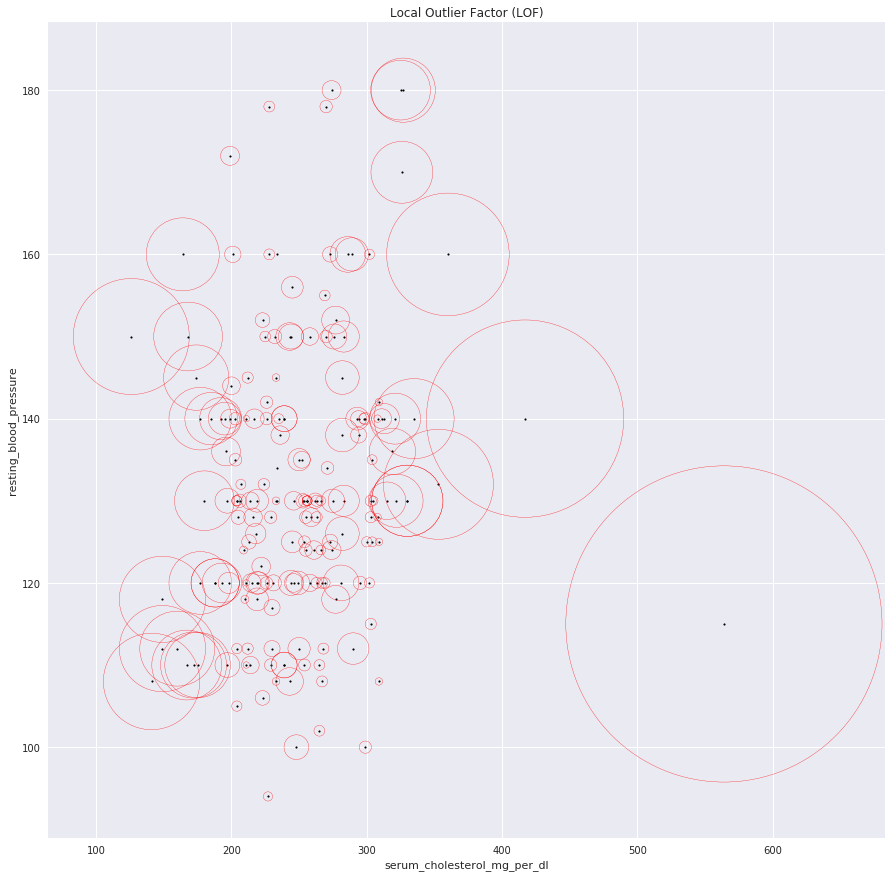

In [10]:
plt.figure(figsize=(15, 15))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(x, y, color='k', s=3., label='Data points')

radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

plt.scatter(x, y, s=100000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')

plt.axis('tight')
plt.xlabel(xlab)
plt.ylabel(ylab)

plt.show()

In [11]:

radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())


trace1 = go.Scatter(
    x = x,
    y = y,
    name = 'data',
    mode = 'markers',
    hoverinfo = 'text',
    text = ['x: %s<br>y: %s' % (x_i, y_i) for x_i, y_i in zip(x, y)]
)

trace2 = go.Scatter(
    x = x,
    y = y,
    name = 'data',
    mode = 'markers',
    hoverinfo = 'text',
    text = ['radius: %s' % round(rad, 2) for rad in radius],
    marker=dict(
        size = 200 * radius,
    )
)
data = [trace1, trace2]


layout = go.Layout(
    xaxis = dict({'title': xlab}),
    yaxis = dict({'title': ylab})
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, layout)

## Projection methods

https://scikit-learn.org/stable/modules/unsupervised_reduction.html

## Autoencoders

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

## Decision Trees

In [12]:
df.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [13]:
# fit the model
clf = IsolationForest(
#     behaviour='new',
    max_samples=100,
    random_state=22, contamination='auto')

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [14]:
xlab = 'serum_cholesterol_mg_per_dl'
ylab = 'resting_blood_pressure'

x = df[xlab].apply(float)
y = df[ylab].apply(float)

X_train = np.array(x,y).reshape(-1, 1)

In [15]:
clf.fit(X_train)

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [16]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

AttributeError: 'IsolationForest' object has no attribute 'threshold_'

In [17]:
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

IndexError: index 1 is out of bounds for axis 1 with size 1

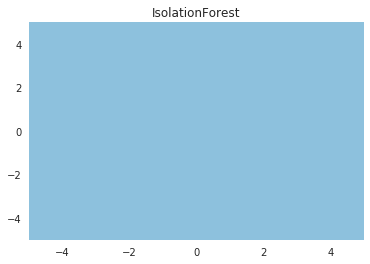

In [18]:
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

# Glass Dataset

Data information:
+ http://odds.cs.stonybrook.edu/glass-data/
+ https://archive.ics.uci.edu/ml/datasets/Glass+Identification


## Import data

In [19]:
%%bash
ls ./ | grep glass

glass.data.txt


In [20]:
df_glass = pd.read_csv(
    'glass.data.txt',
    header=None,
    names=['ID', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'GType']
).drop('ID', axis=1)

# http://odds.cs.stonybrook.edu/glass-data/
# > Here, class 6 is a clear minority class, as such points of class 6
# are marked as outliers, while all other points are inliers.
df_glass['GOut'] = df_glass.GType.apply(lambda x: 1 if x != 6 else 0)

gtypes = {
    1: 'building_windows_float_processed',
    2: 'building_windows_non_float_processed',
    3: 'vehicle_windows_float_processed',
    4: 'vehicle_windows_non_float_processed',
    5: 'containers',
    6: 'tableware',
    7: 'headlamps'
}

gouts = {
    0: 'outlier',
    1: 'common'
}

df_glass.info()
df_glass.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
RI       214 non-null float64
Na       214 non-null float64
Mg       214 non-null float64
Al       214 non-null float64
Si       214 non-null float64
K        214 non-null float64
Ca       214 non-null float64
Ba       214 non-null float64
Fe       214 non-null float64
GType    214 non-null int64
GOut     214 non-null int64
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,GType,GOut
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1,1


In [21]:
print(df_glass.GType.value_counts())
print(df_glass.GOut.value_counts())

2    76
1    70
7    29
3    17
5    13
6     9
Name: GType, dtype: int64
1    205
0      9
Name: GOut, dtype: int64


## Pairplots by class

CPU times: user 14.6 s, sys: 8.92 s, total: 23.5 s
Wall time: 12.5 s


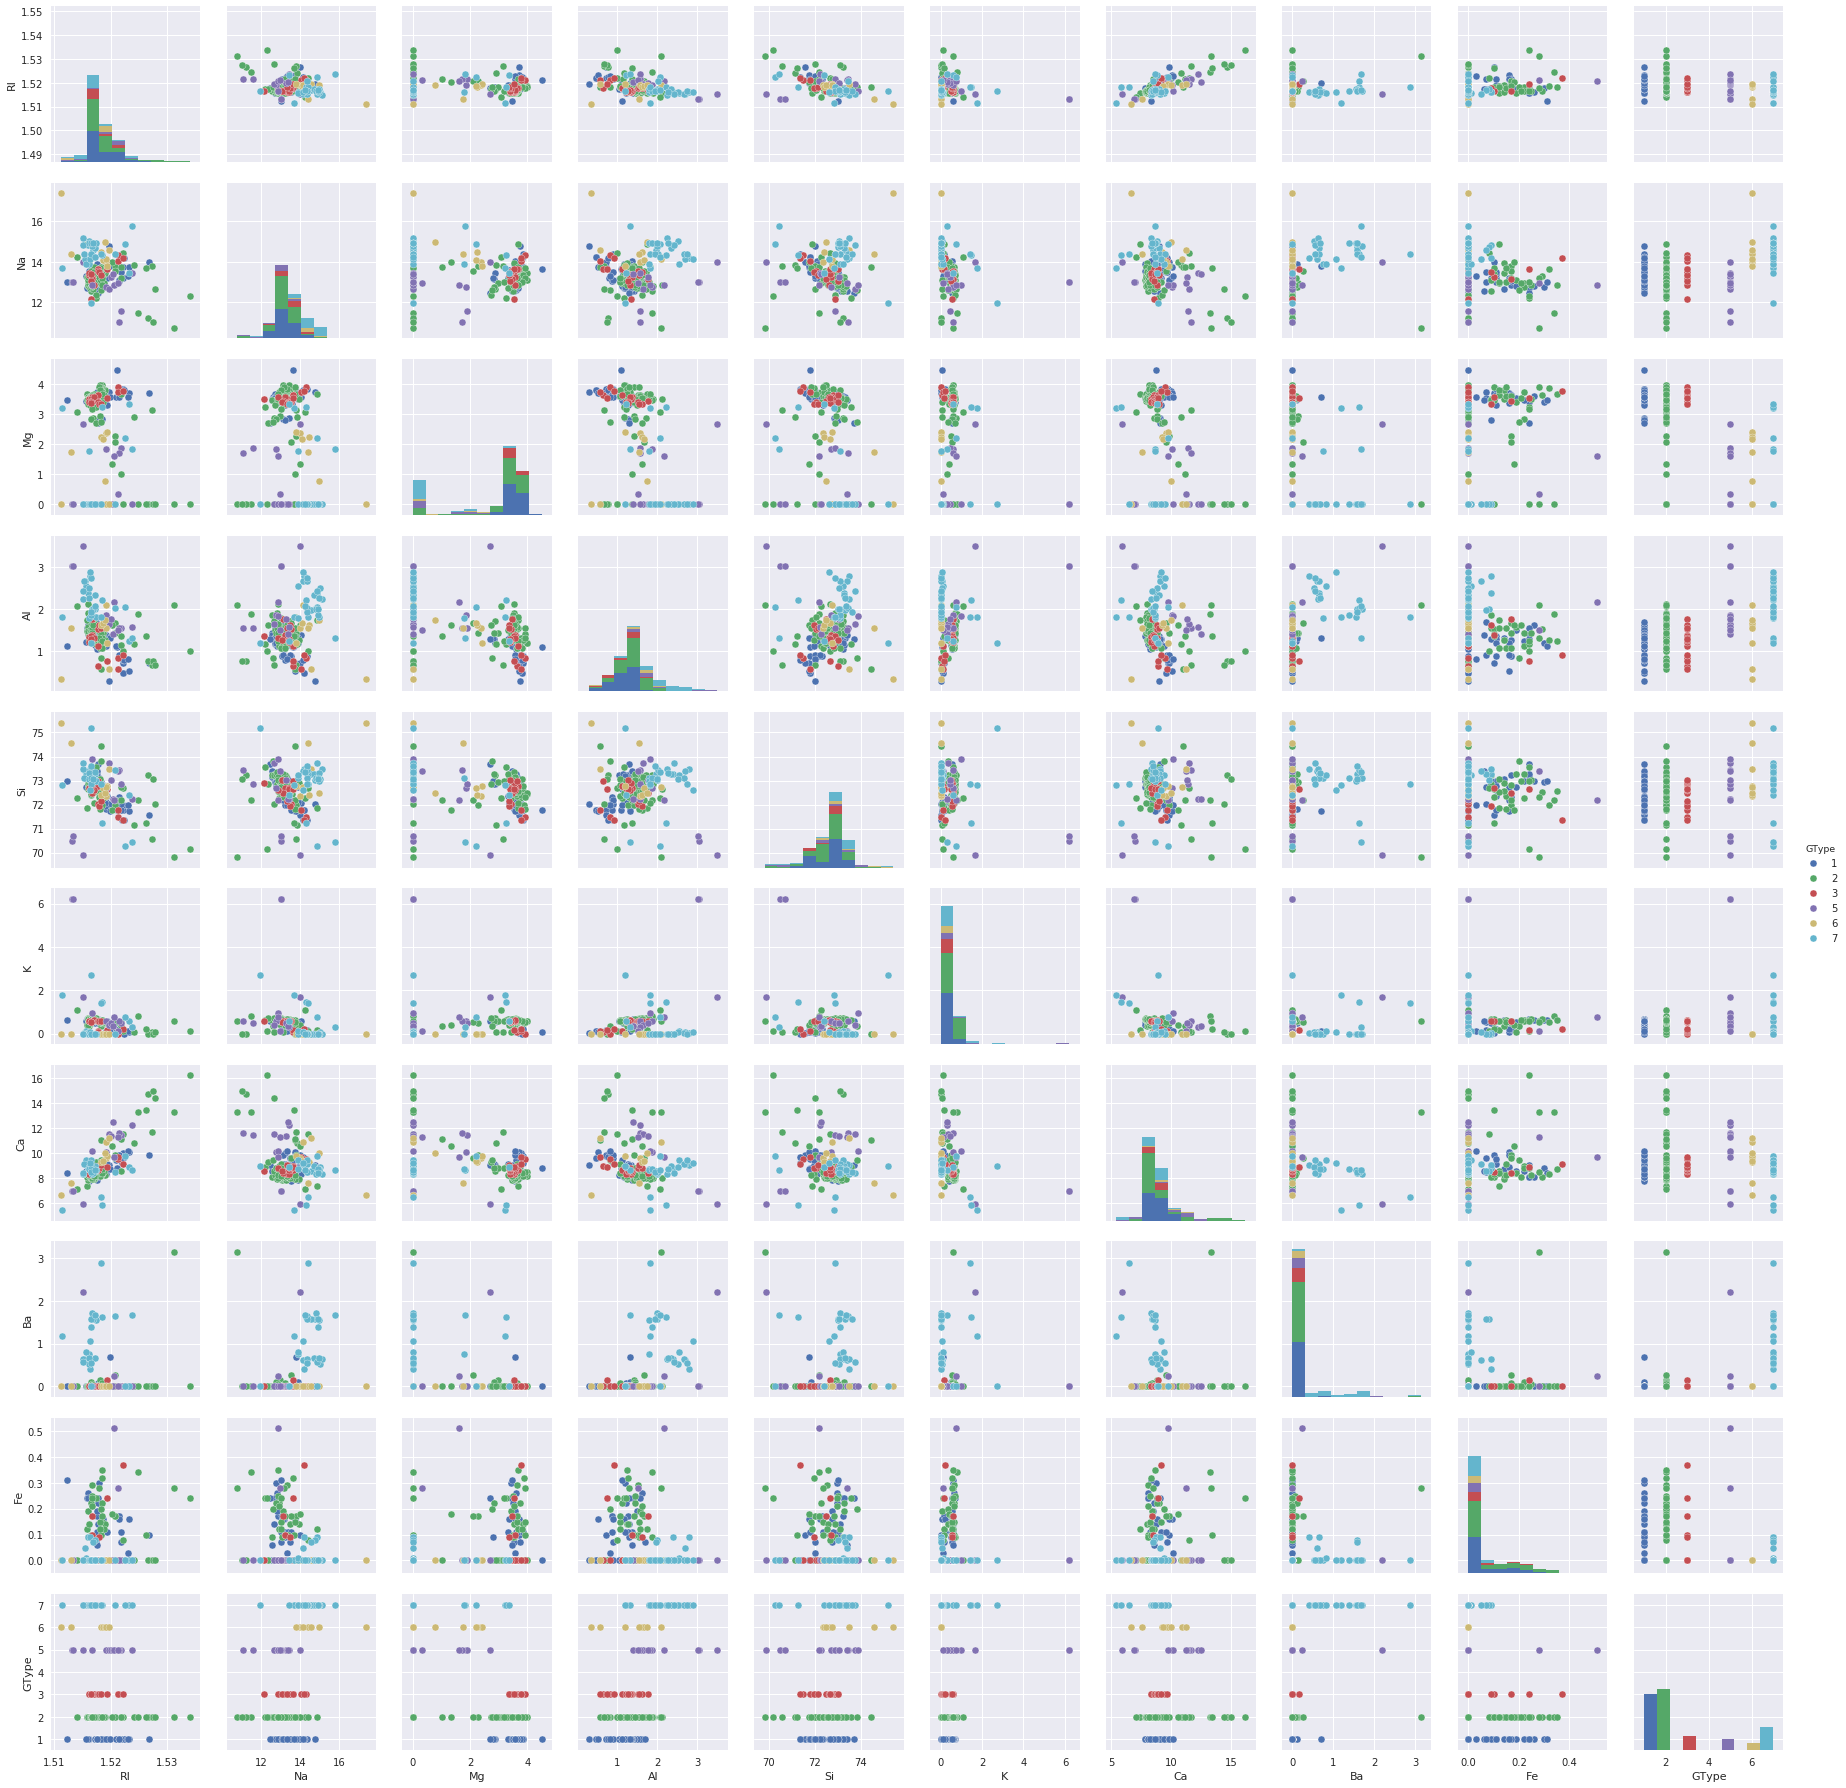

In [22]:
%%time
sns.pairplot(df_glass.drop('GOut', axis=1), hue='GType')

CPU times: user 11.4 s, sys: 6.25 s, total: 17.6 s
Wall time: 9.65 s


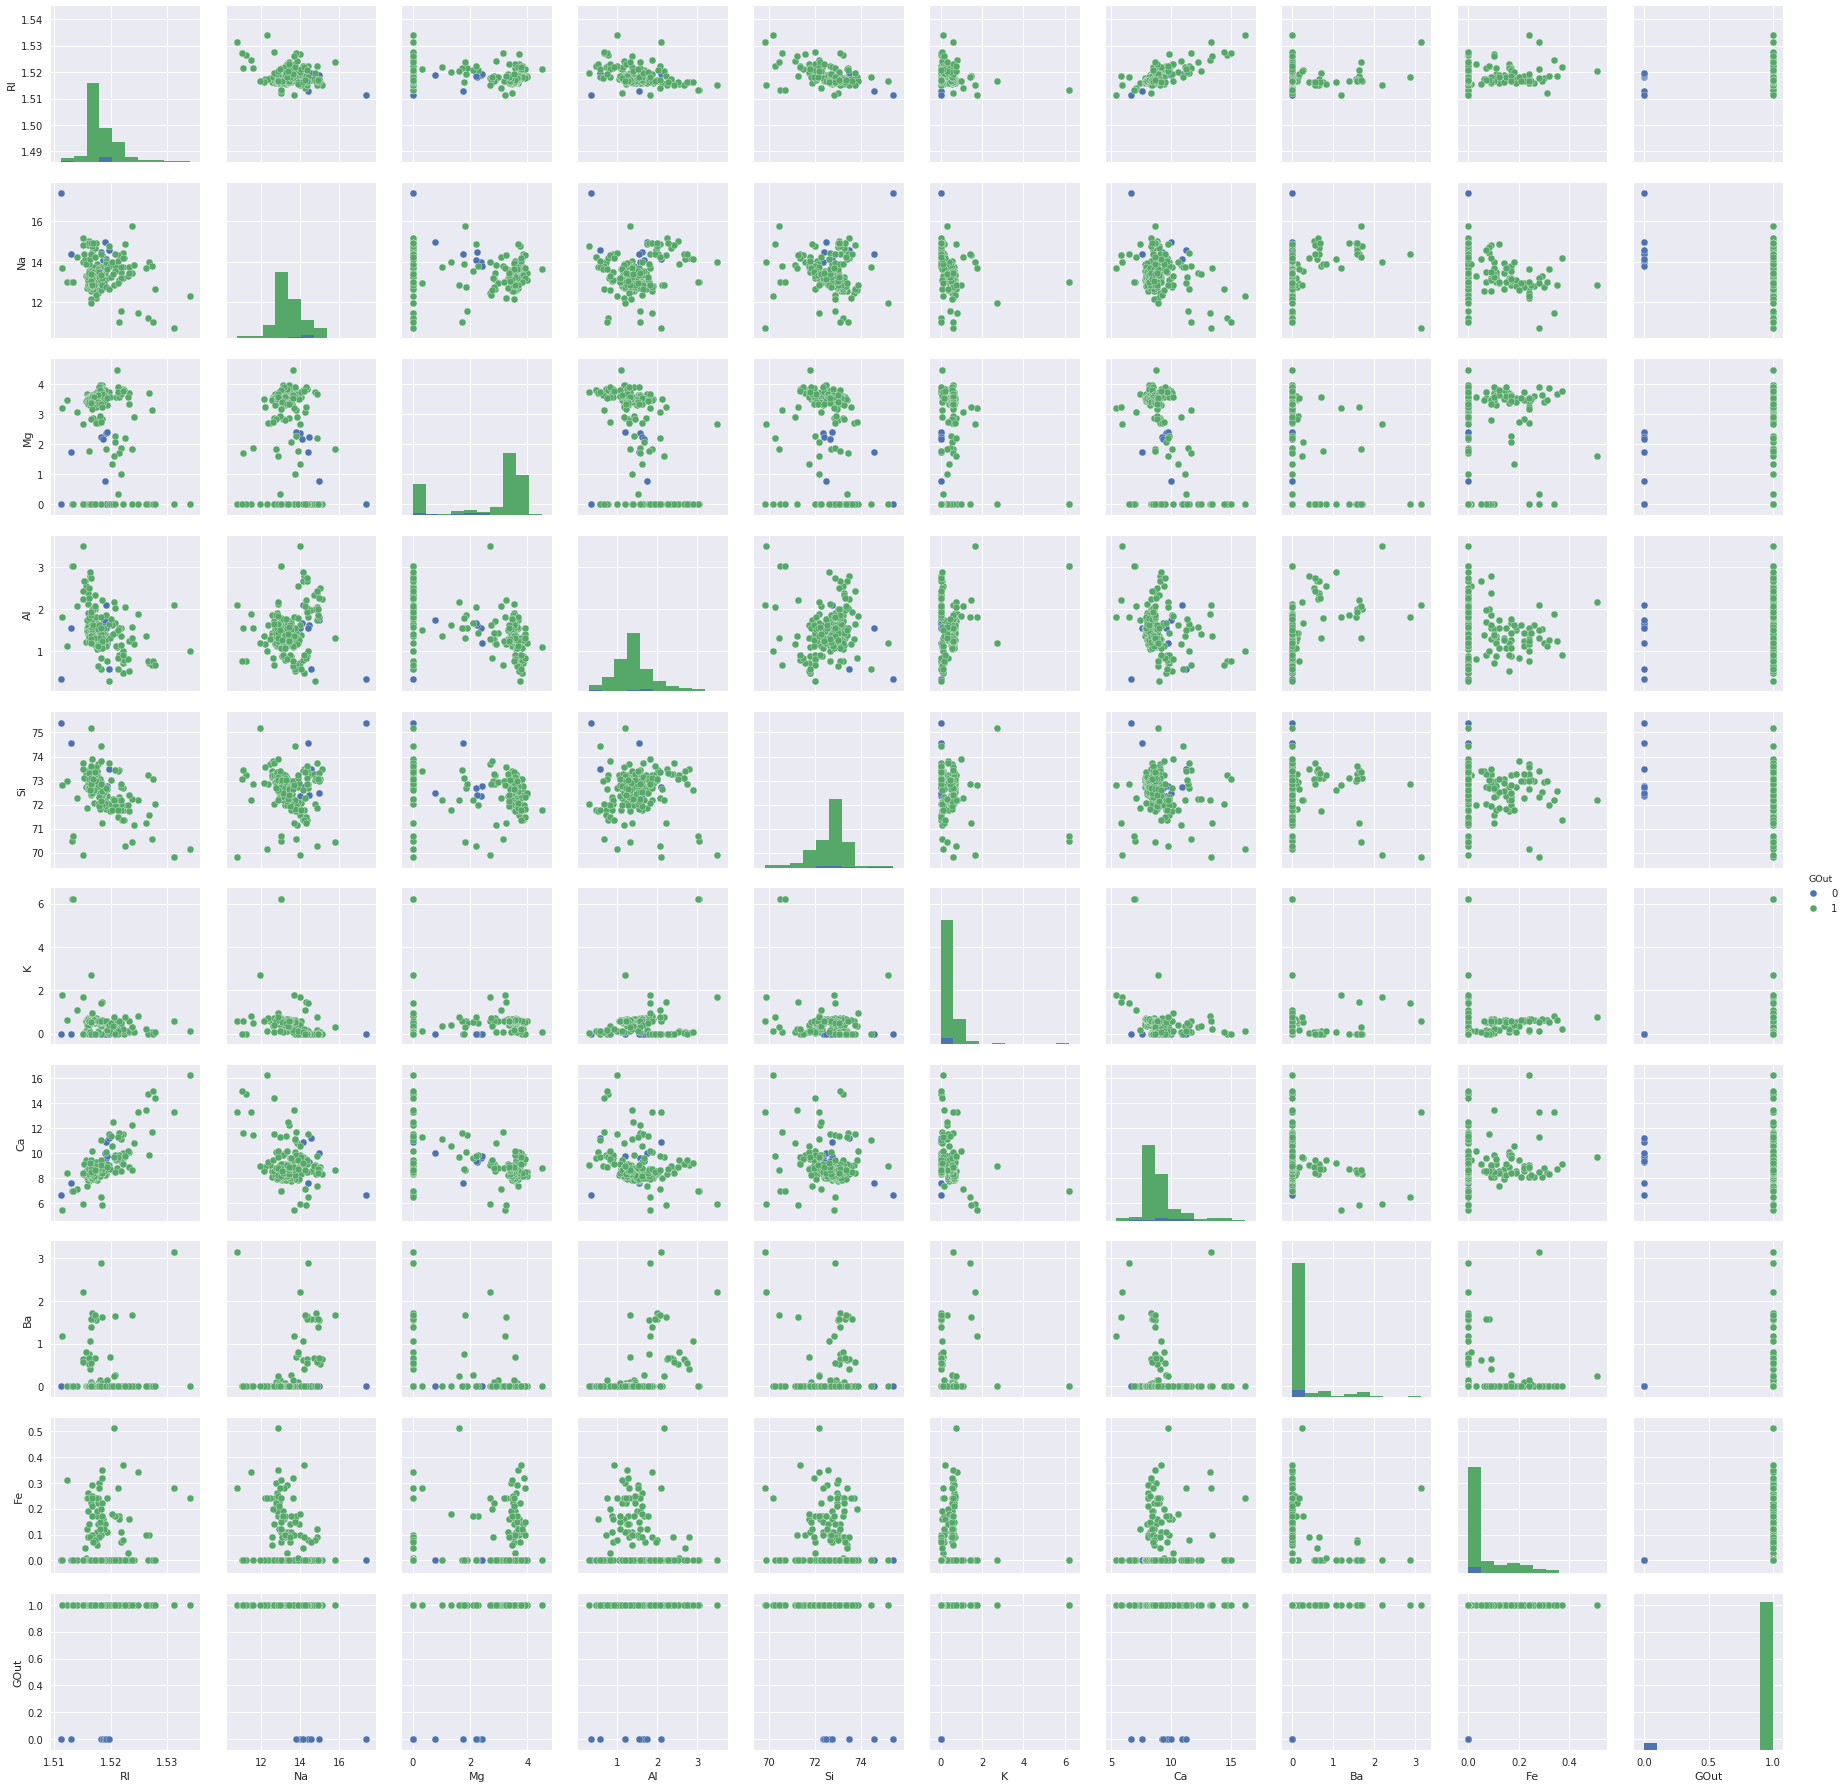

In [23]:
%%time
sns.pairplot(df_glass.drop('GType', axis=1), hue='GOut')

## UIF / UOF - 1.5 * IQR rule

In [29]:
name = 'RI'
y = df_glass[name]

trace1 = go.Box(
    y=y,
    jitter=0.3,
    pointpos=-1.8,
    boxpoints = 'all',
    marker = dict(
        color = 'rgb(8,81,156)',
    ),
    name = name
)

trace2 = go.Box(
    y=y,
    jitter=0.3,
    pointpos=-1.8,
    boxpoints = 'suspectedoutliers',
    marker = dict(
        color = 'rgb(8,81,156)',
        outliercolor = 'rgba(219, 64, 82, 0.6)',
        line = dict(
            outliercolor = 'rgba(219, 64, 82, 0.6)',
            outlierwidth = 2)
    ),
    name = name + ' - suspected outliers'
)

data = [trace1, trace2]

layout = go.Layout(
    showlegend = False
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, layout)

In [30]:
name = 'RI'
y = df_glass[name]

q1, q3 = np.percentile(y, [25, 75])
iqr = q3 - q1

uof = q3 + 3   * iqr
uif = q3 + 1.5 * iqr
lif = q1 - 1.5 * iqr
lof = q3 - 3   * iqr

print('Upper outer fence: %s' % uof)
print('Upper inner fence: %s' % uif)
print('Lower inner fence: %s' % lif)
print('Lower outer fence: %s' % lof)

Upper outer fence: 1.527062499999999
Upper inner fence: 1.5231099999999995
Lower inner fence: 1.5125700000000006
Lower outer fence: 1.5112525000000008


In [31]:
X_train = df_glass[['RI', 'Mg']]
X_train = X_train.values.tolist()
X_train

[[1.52101, 4.49],
 [1.5176100000000001, 3.6],
 [1.5161799999999999, 3.55],
 [1.51766, 3.69],
 [1.51742, 3.62],
 [1.51596, 3.61],
 [1.5174299999999998, 3.6],
 [1.51756, 3.61],
 [1.51918, 3.58],
 [1.51755, 3.6],
 [1.5157100000000001, 3.46],
 [1.51763, 3.66],
 [1.51589, 3.43],
 [1.51748, 3.56],
 [1.51763, 3.59],
 [1.5176100000000001, 3.54],
 [1.5178399999999999, 3.67],
 [1.52196, 3.85],
 [1.51911, 3.73],
 [1.51735, 3.54],
 [1.5175, 3.55],
 [1.51966, 3.75],
 [1.51736, 3.62],
 [1.5175100000000001, 3.57],
 [1.5172, 3.5],
 [1.5176399999999999, 3.54],
 [1.51793, 3.48],
 [1.51721, 3.48],
 [1.51768, 3.52],
 [1.5178399999999999, 3.49],
 [1.51768, 3.56],
 [1.51747, 3.5],
 [1.51775, 3.48],
 [1.5175299999999998, 3.47],
 [1.51783, 3.54],
 [1.51567, 3.45],
 [1.51909, 3.53],
 [1.51797, 3.48],
 [1.52213, 3.82],
 [1.52213, 3.82],
 [1.51793, 3.5],
 [1.51755, 3.42],
 [1.51779, 3.39],
 [1.5221, 3.84],
 [1.51786, 3.43],
 [1.519, 3.48],
 [1.5186899999999999, 3.37],
 [1.52667, 3.7],
 [1.52223, 3.77],
 [1.51898

In [32]:
y_mild_outliers = df_glass[(df_glass.RI >= uif) & (df_glass.RI < uof)][['RI', 'Mg']]
y_mild_outliers = y_mild_outliers.values.tolist()
y_mild_outliers

[[1.52667, 3.7],
 [1.5232, 3.72],
 [1.5241, 2.9],
 [1.52475, 0.0],
 [1.52664, 0.0],
 [1.52614, 0.0],
 [1.52369, 0.0],
 [1.52315, 3.34],
 [1.52365, 1.83]]

In [33]:
# y_extr_outliers = df_glass[df_glass.RI >= uof]['RI']
# y_extr_outliers = list(y_extr_outliers)
y_extr_outliers = df_glass[df_glass.RI >= uof][['RI', 'Mg']]
y_extr_outliers = y_extr_outliers.values.tolist()
y_extr_outliers

[[1.52725, 3.15],
 [1.53125, 0.0],
 [1.53393, 0.0],
 [1.52739, 0.0],
 [1.52777, 0.0]]

In [34]:
name1 = 'RI'
name2 = 'Mg'

traces = []

for gtyp in df_glass.GOut.unique():
    x = df_glass[df_glass.GOut == gtyp][name1]
    y = df_glass[df_glass.GOut == gtyp][name2]

    trace = go.Scatter(
        x=x,
        y=y,
        mode='markers',
        #marker = dict(
        #    color = 'rgb(8,81,156)',
        #),
        # name = gtypes[gtyp]
        text = gouts[gtyp],
        hoverinfo = 'text'
    )
    traces.append(trace)

layout = go.Layout(
    hovermode= 'closest',
    showlegend = False,
    xaxis = dict({
        'title': name1
    }),
    yaxis = dict({
        'title': name2
    })
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig, layout)

## UIF - Precision / Recall

Identified outliers: 9
True outliers: 9
------------------
Precision: 0.956
Recall: 0.956
AUC: 0.522


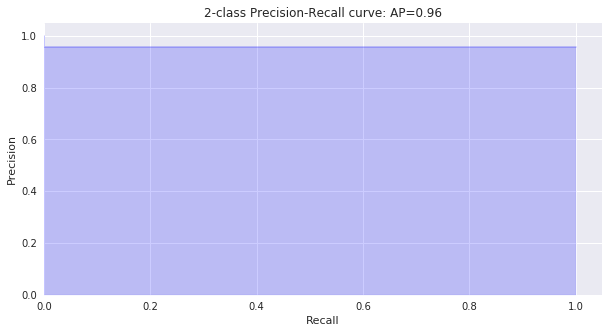

In [35]:
plt.figure(figsize=(10,5))

y_mild_outliers = df_glass.RI

y_pred = pd.Series(y_mild_outliers)
# inverse_lof of -1 => normal, while outliers have a smaller number
y_pred = y_pred.apply(lambda x: 0 if (x >= uif) & (x < uof) else 1)


y_true = df_glass.GOut

print('Identified outliers: %s' % y_pred.value_counts()[0])
print('True outliers: %s' % y_true.value_counts()[0])

print('---' * 6)

print('Precision: %s' % round(average_precision_score(y_true, y_pred), 3))
print('Recall: %s' % round(recall_score(y_true, y_pred), 3))
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=0)
print('AUC: %s' % round(auc(fpr, tpr), 3))

precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()

Identified outliers: 5
True outliers: 9
------------------
Precision: 0.957
Recall: 0.976
AUC: 0.512


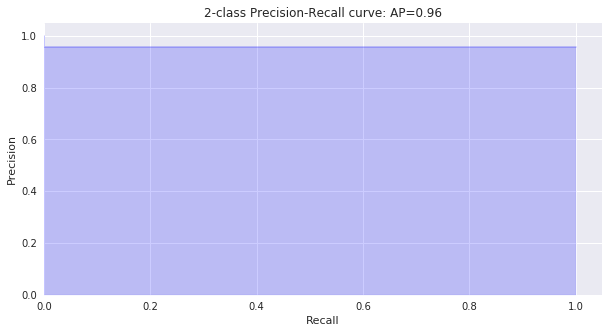

In [36]:
plt.figure(figsize=(10,5))

y_mild_outliers = df_glass.RI

y_pred = pd.Series(y_mild_outliers)
# inverse_lof of -1 => normal, while outliers have a smaller number
y_pred = y_pred.apply(lambda x: 0 if x >= uof else 1)


y_true = df_glass.GOut

print('Identified outliers: %s' % y_pred.value_counts()[0])
print('True outliers: %s' % y_true.value_counts()[0])

print('---' * 6)

print('Precision: %s' % round(average_precision_score(y_true, y_pred), 3))
print('Recall: %s' % round(recall_score(y_true, y_pred), 3))
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=0)
print('AUC: %s' % round(auc(fpr, tpr), 3))

precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()

## Mahalanobis

In [37]:
x = df_glass['Mg']
y = df_glass['RI']

X = np.vstack([x,y])
V = np.cov(X.T)
vi = inv(V) # np.linalg.inv

distance.mahalanobis(x, y, vi)

LinAlgError: singular matrix

## LOF

In [38]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

x = df_glass[name1]
y = df_glass[name2]
y_pred = clf.fit_predict(np.array(x,y).reshape(-1, 1))
X_scores = clf.negative_outlier_factor_

print(X_scores[:20])


radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())


trace1 = go.Scatter(
    x = x,
    y = y,
    name = 'data',
    mode = 'markers',
    hoverinfo = 'text',
    text = ['x: %s<br>y: %s' % (x_i, y_i) for x_i, y_i in zip(x, y)]
)

trace2 = go.Scatter(
    x = x,
    y = y,
    name = 'data',
    mode = 'markers',
    hoverinfo = 'text',
    text = ['radius: %s' % round(rad, 2) for rad in radius],
    marker=dict(
        size = 100 * radius,
    )
)
data = [trace1, trace2]


layout = go.Layout(
    xaxis = dict({'title': name1}),
    yaxis = dict({'title': name2})
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, layout)

[-1.00408343 -0.95669141 -0.98494003 -0.95647426 -1.04709688 -0.96309983
 -1.03891049 -0.96440909 -1.12064995 -0.98905    -1.20515743 -0.95295927
 -1.04744413 -1.00326658 -0.95295927 -0.95669141 -1.0620618  -0.96850966
 -1.14023475 -1.1470066 ]


## LOF - Precision / Recall

Identified outliers: 16
True outliers: 9
------------------
Precision: 0.964
Recall: 0.932
AUC: 0.423


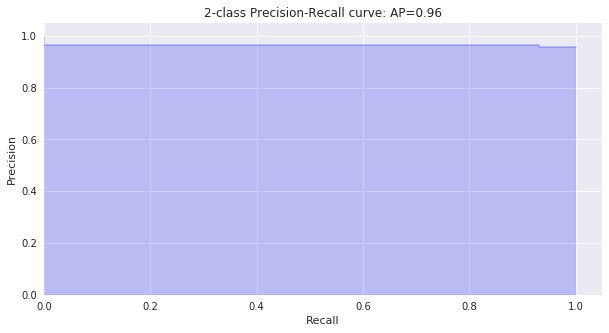

In [39]:
plt.figure(figsize=(10,5))

y_pred = pd.Series(X_scores)
# inverse_lof of -1 => normal, while outliers have a smaller number
y_pred = y_pred.apply(lambda x: 0 if x < -2.5 else 1)


y_true = df_glass.GOut

print('Identified outliers: %s' % y_pred.value_counts()[0])
print('True outliers: %s' % y_true.value_counts()[0])

print('---' * 6)

print('Precision: %s' % round(average_precision_score(y_true, y_pred), 3))
print('Recall: %s' % round(recall_score(y_true, y_pred), 3))
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=0)
print('AUC: %s' % round(auc(fpr, tpr), 3))

precision, recall, _ = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()

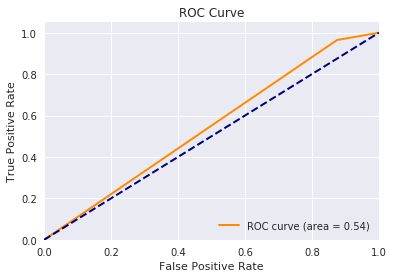

In [40]:
# ROC / AUC curve

plt.figure()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# for i in range(2):
#     fpr[i], tpr[i], _ = roc_curve(y_pred[:, i], y_true[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

fpr, tpr, _ = roc_curve(y_pred, y_true)
roc_auc = auc(fpr, tpr)


lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Precision / Recall

compare outliers from every method extracted to labels in the dataset (not some other measure to identify outliers)

+ https://en.wikipedia.org/wiki/Precision_and_recall
+ https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
+ https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
+ https://stackoverflow.com/questions/44468172/valueerror-continuous-format-is-not-supported
+ https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py
+ https://scikit-learn.org/stable/auto_examples/plot_johnson_lindenstrauss_bound.html#sphx-glr-auto-examples-plot-johnson-lindenstrauss-bound-py
+ https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py


In [41]:

average_precision = average_precision_score(y_pred, X_scores)

average_precision

0.9999999999999999

In [42]:
from sklearn.preprocessing import label_binarize

Y = label_binarize(y, classes=[0, 1, 2])
n_classes = Y.shape[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=random_state)

from sklearn.multiclass import OneVsRestClassifier

classifier = OneVsRestClassifier(svm.LinearSVC(random_state=random_state))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

ValueError: continuous target data is not supported with label binarization

In [43]:
# fit the model
clf = IsolationForest(
    # behaviour='new',
    max_samples=100,
    random_state=22, contamination='auto')

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [44]:
clf.fit(X_train)

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [45]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

AttributeError: 'IsolationForest' object has no attribute 'threshold_'

In [46]:
# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

TypeError: list indices must be integers or slices, not tuple

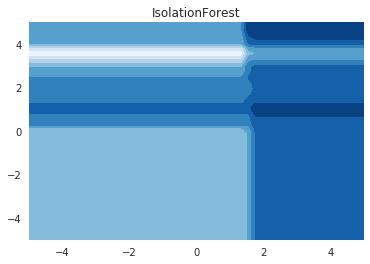

In [47]:
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

---